<a href="https://colab.research.google.com/github/emanuel379/-Introducao-a-Ciencia-de-Dados/blob/main/Projeto_Final_ICD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SME0828 - Introdução à Ciência de Dados

### Projeto Final - Previsão de preços de casas a partir de suas características

##### Integrantes:
Ada Maris Pereira Mário ---- 12725432

Emanuel Victor da Silva Favorato ---- 12558151

Katiely Feitosa de Lacerda ---- 12777100

### Introdução

O projeto em questão tem como objetivo responder à pergunta: "É possível prever o preço de casas a partir de suas características?". Para isso, selecionamos uma base de dados do Departamento de Censo dos EUA com dados sobre o censo na Califórnia com 10 diferentes métricas para cada bloco desse estado.

O dataset está disponível neste [link](https://www.kaggle.com/datasets/shibumohapatra/house-price).

O dataset conta com 10 atributos, sendo eles:

**longitude:** Atributo numérico. Longitude da região;

**latitude:** Atributo numérico. Latitude da região;

**housing_median:** Atributo numérico. Mediana das idades das casas na região;

**total_rooms:** Atributo numérico. Total de cômodos, juntando todas as casas na região;

**total_bedrooms:** Atributo numérico. Total de quartos, juntando todas as casas na região;

**population:** Atributo numérico. População na região.

**households:** Atributo numérico. Casas para moradia na região;

**median_income:** Atributo numérico. Renda média das pessoas na região.

**ocean_proximity:** Atributo categórico. Proximidade com o oceano.

**median_house_value:** Atributo numérico. Mediana dos valores das casas.

### Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import variation
import statsmodels.api as sm
import plotly.express as px
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

### Abertura e Preparação dos dados

In [ ]:
df = pd.read_csv('housing.csv', header=(0))
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


In [ ]:
df.shape

(20640, 10)

Como visto, temos um conjunto de dados com 20640 instâncias e 10 atributos. Vejamos agora algumas informações e estatísticas básicas dos nossos dados:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


Vemos que o atributo "ocean_proximity" é o único nominal em meio aos demais numéricos.

In [ ]:
#informações do dataFrame
df.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


Aqui podemos notar algumas variáveis com variância alta, como "total_rooms", "total_bedrooms", "population" e a própria variável resposta "median_house_value". Entretanto, temos que ter em mente que, por se tratar de atributos com um range amplo, é natural que tais desvios também sejam amplos.


Por isso, vejamos o coeficiente de variação das covariáveis para verificar a dispersão dos valores de acordo com suas médias:

In [ ]:
variation(df.drop(columns='ocean_proximity'))

array([-0.01675578,  0.05994356,  0.4394371 ,  0.82767773,         nan,
        0.79442523,  0.76534559,  0.49081301,  0.5578418 ])

### Limpeza e organização dos dados

Inicialmente, vamos fazer uma preparação dos dados. Temos quase 21k de instâncias na planílha e algumas inconsistências.  Como teremos que fazer one-hot-encoding da variável categórica, vamos inicialmente padronizar suas respostas para terem todas letras minúsculas e assim as apresentações das colunas serem similares.

In [ ]:
# Vamos começar preparando as colunas com valores string

string_columns= list(df.dtypes[df.dtypes == 'object'].index)
string_columns

['ocean_proximity']

In [ ]:
# Vamos deixar todos os atributos em minúsculo e substituir espaços por '_'

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [ ]:
# Conferindo os dados novamente:

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,near_bay,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,near_bay,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,near_bay,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,near_bay,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,near_bay,342200




Agora, verificamos os valores nulos contidos no conjunto:

In [ ]:
#número de valores ausentes em cada coluna
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

Vamos substituir os valores NaN presentes no atributo "total_bedrooms" pela mediana desta coluna.

In [ ]:
#preenche os valores ausentes com a mediana
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

Conferindo novamente se ainda restam NaN:

Vamos verificar de novo os coeficientes de variação:

In [ ]:
variation(df.drop(columns='ocean_proximity'))

array([-0.01675578,  0.05994356,  0.4394371 ,  0.82767773,  0.78120597,
        0.79442523,  0.76534559,  0.49081301,  0.5578418 ])

Finalmente, vamos converter os atributos categóricos em numéricos utilizando one-hot-encoding.

In [ ]:
#conferindo se está zerado
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
median_house_value    0
dtype: int64

In [ ]:
df_original = df
df = pd.get_dummies(df)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1h_ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near_bay,ocean_proximity_near_ocean
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,0,0,0,1,0
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,0,0,0,1,0
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,0,0,0,1,0
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,0,0,0,1,0
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,0,0,0,1,0


In [ ]:
# Observando estatísticas importantes após as mudanças
df.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1h_ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near_bay,ocean_proximity_near_ocean
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,536.84,1425.48,499.54,3.87,206855.82,0.44,0.32,0.00,0.11,0.13
std,2.00,2.14,12.59,2181.62,419.39,1132.46,382.33,1.90,115395.62,0.50,0.47,0.02,0.31,0.33
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00,0.00,0.00,0.00,0.00,0.00
25%,-121.80,33.93,18.00,1447.75,297.00,787.00,280.00,2.56,119600.00,0.00,0.00,0.00,0.00,0.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00,0.00,0.00,0.00,0.00,0.00
75%,-118.01,37.71,37.00,3148.00,643.25,1725.00,605.00,4.74,264725.00,1.00,1.00,0.00,0.00,0.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00,1.00,1.00,1.00,1.00,1.00


### Análise exploratória dos dados

Inicialmente, vamos avaliar a correlação entre os atributos, a fim de analisar quais são relevantes para a determinação do preço da casa.


Text(0.5, 1.0, 'Correlação de Pearson')

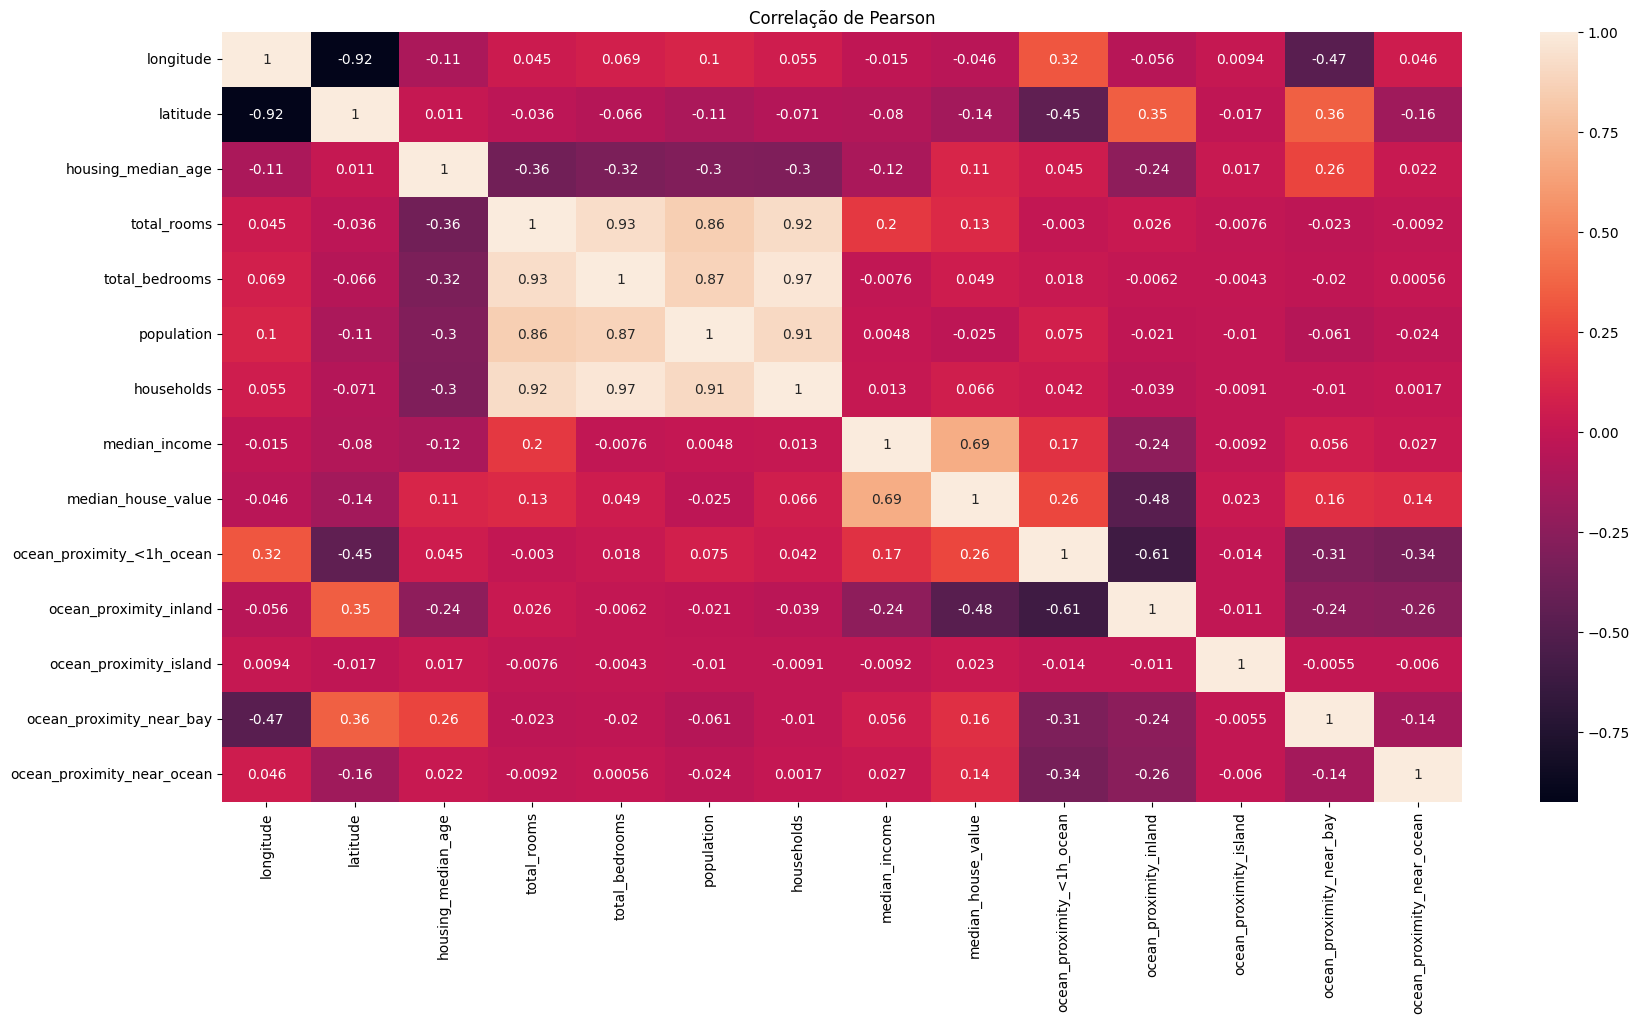

In [ ]:
plt.figure(figsize =(20, 10))
sns.heatmap(df.corr(), annot = True) # Mapa de calor, onde  annot insere os valores dentro das ilhas
plt.title('Correlação de Pearson')

Pela tabela acima podemos tirar algumas informações:
- A média dos valores das casas está bem ligado a sua proximidade com o oceano, (casas mais próximas ao oceano podem ser mais caras);

- O total de quartos está muito ligado ao total de banheiros, e essa correlação faz muito sentido;

- Tanto o total de quartos como o de banhieros estão muitos ligados a quantidade da população nessa área.


Text(0.5, 1.0, 'Correlação de Spearman')

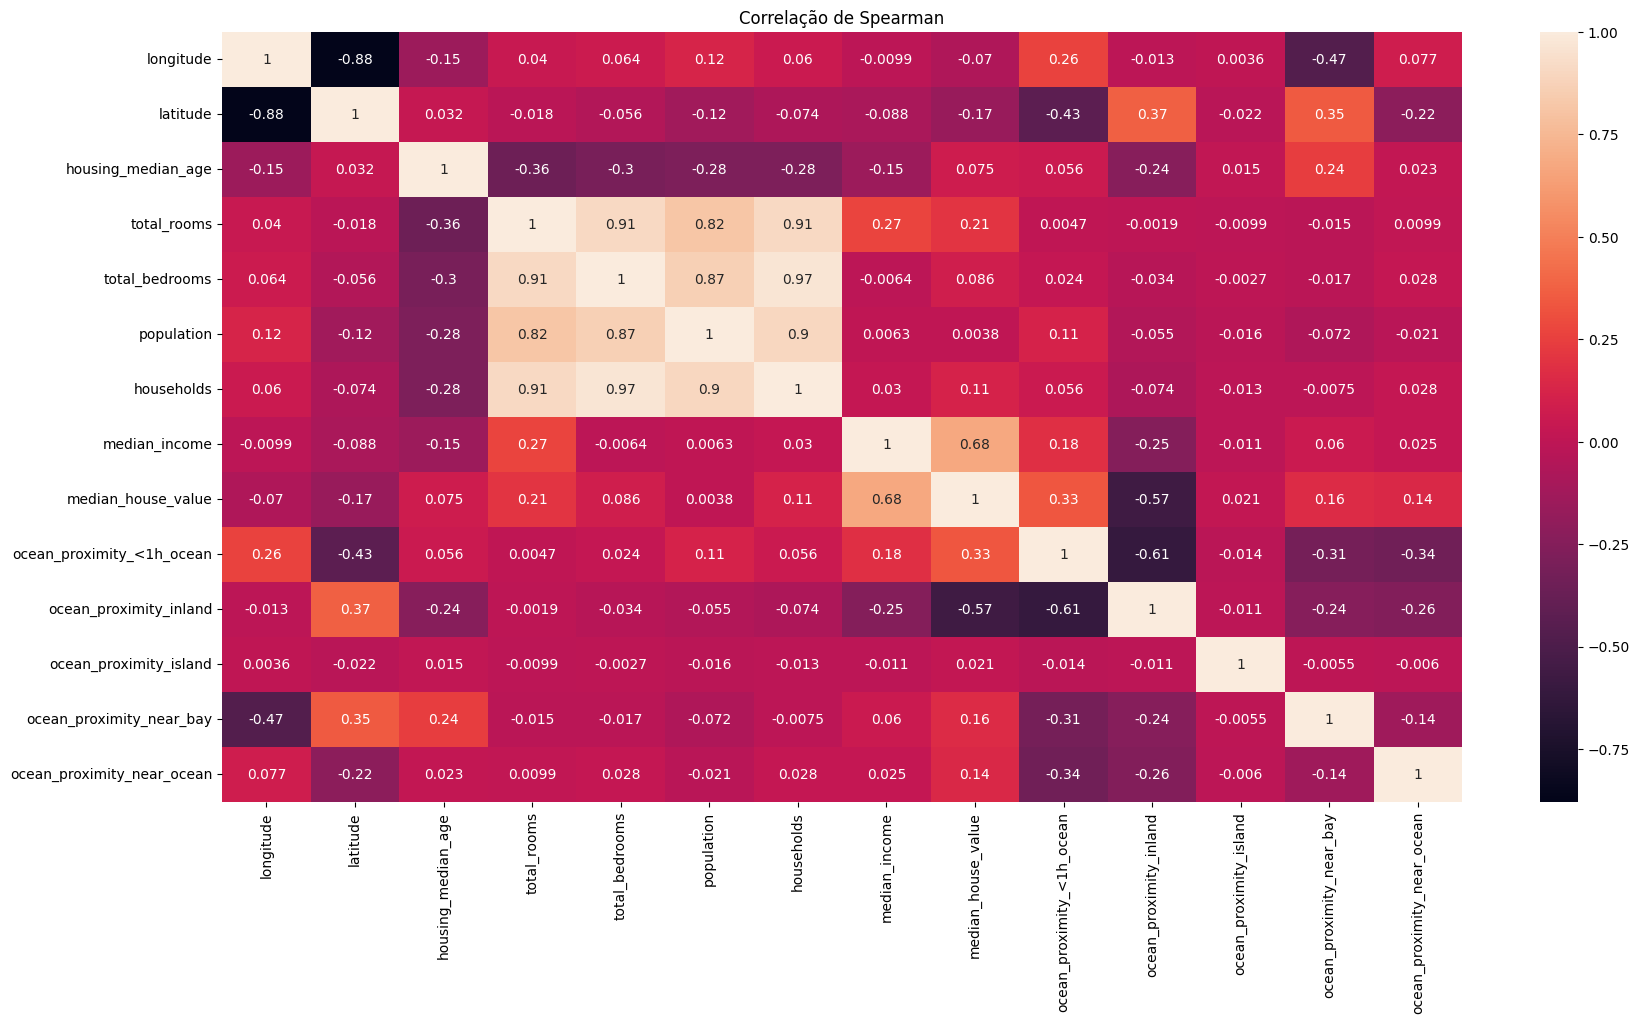

In [ ]:
plt.figure(figsize =(20, 10))
sns.heatmap(df.corr('spearman'), annot = True) # Mapa de calor, onde  annot insere os valores dentro das ilhas
plt.title('Correlação de Spearman')

Quando fazermos a Correlação de Spearman, podemos ver uma relação entre o total de quartos e a mediana das rendas das famílias.

Vemos que "median_income" é o atributo mais promissor para prever "median_house_value" em ambos os tipos de correlação.
Vejamos mais detalhadamente sua distribuição em função deste atributo.

<Axes: xlabel='median_income', ylabel='median_house_value'>

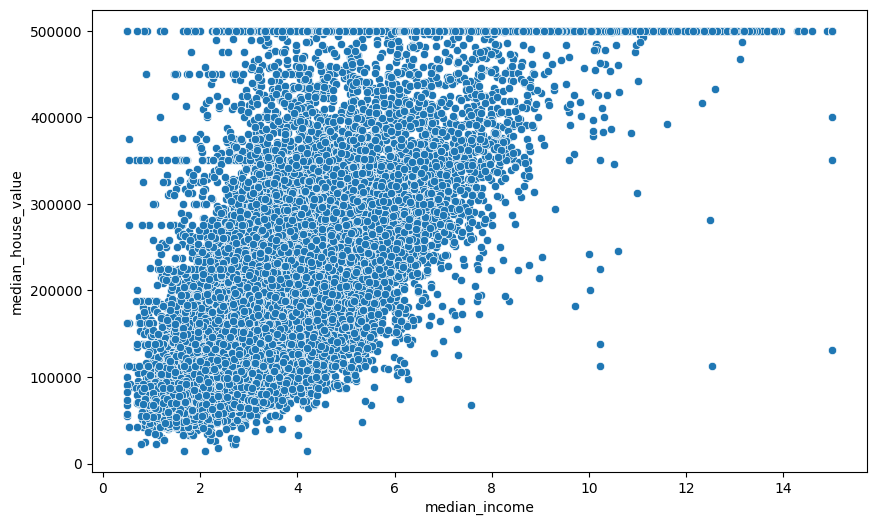

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="median_income", y="median_house_value",data=df)

A linha reta na renda pode significar um limite superior para está variável, ou seja, um teto de valores.

Vejamos também a distribuição da renda conforme a localização das casas:

<Axes: xlabel='latitude', ylabel='longitude'>

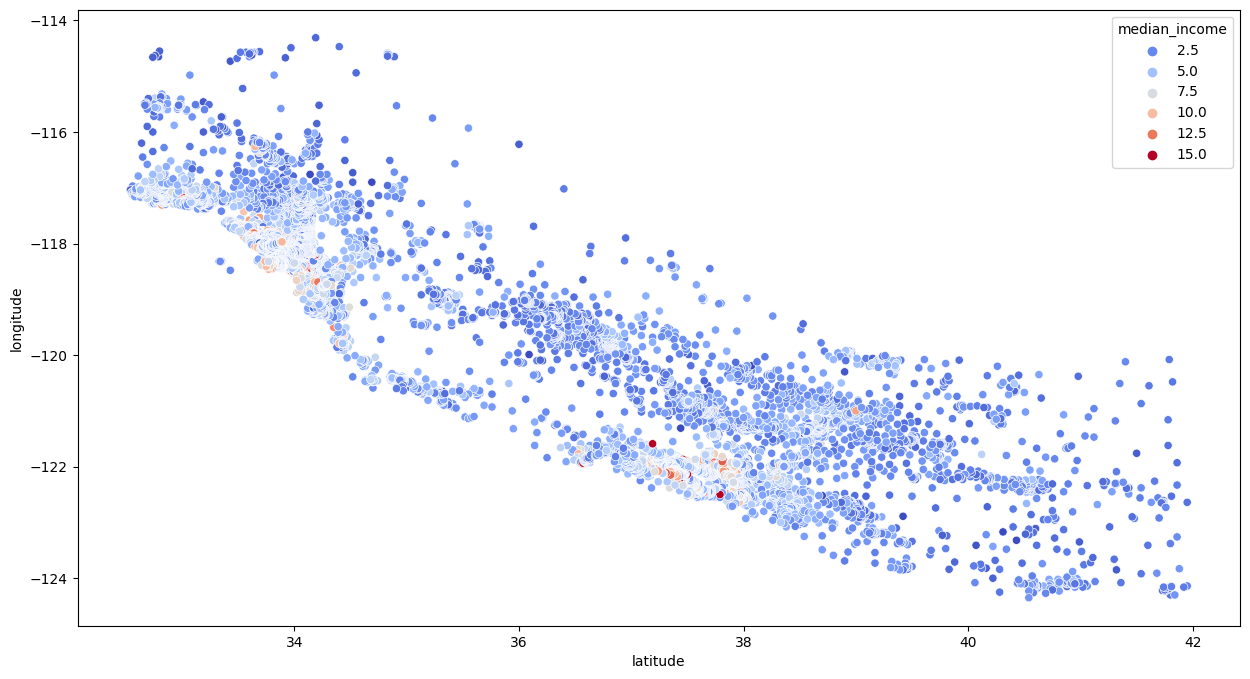

In [ ]:
# verificando a renda de acordo com a latitude e longitude

plt.figure(figsize=(15, 8))
sns.scatterplot(x="latitude", y="longitude",data=df, hue="median_income", palette="coolwarm")

Podemos ver que quando maior a renda, mais ao norte as pessoas moram.

Agora, a distribuição dos preços em função da localização das casas:

<Axes: xlabel='latitude', ylabel='longitude'>

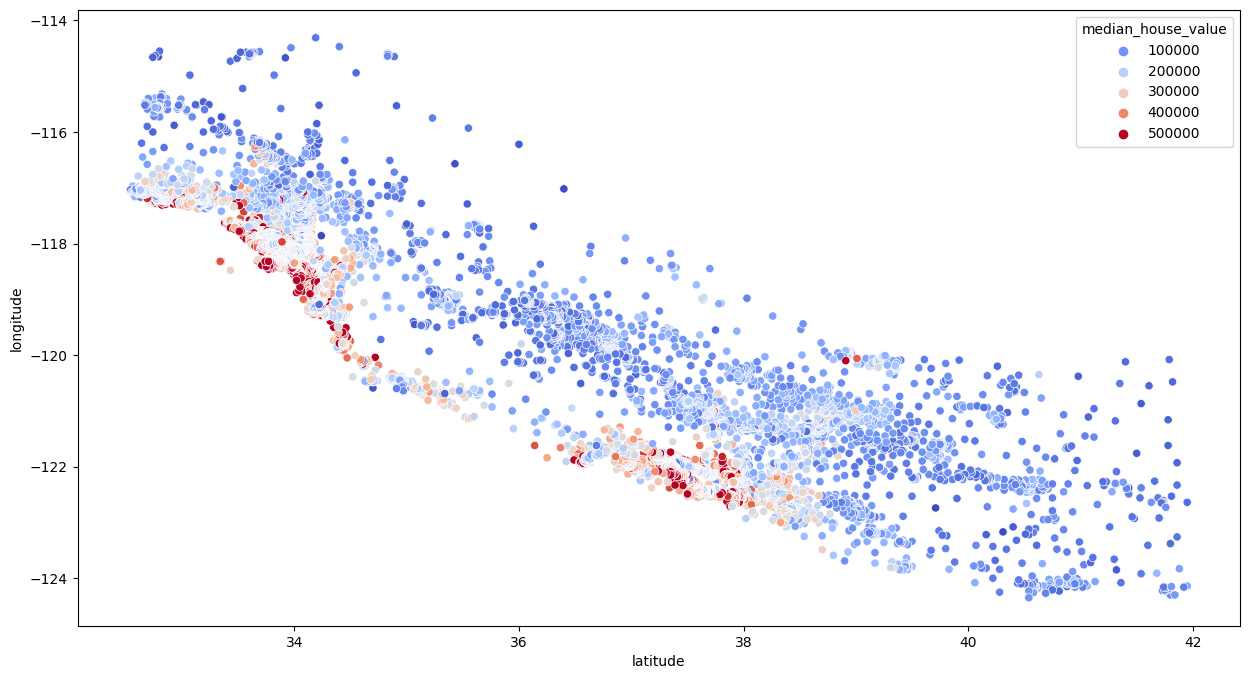

In [ ]:
# comparando a latitude e longitude com a mediana dos valores das casas
plt.figure(figsize=(15, 8))
sns.scatterplot(x="latitude", y="longitude", data=df, hue="median_house_value", palette="coolwarm")

Podemos observar que os maiores índices de renda mediana se concentram em áreas próximas à praia e os menores no interior, bem como a concentração populacional e as casas mais valiosas.

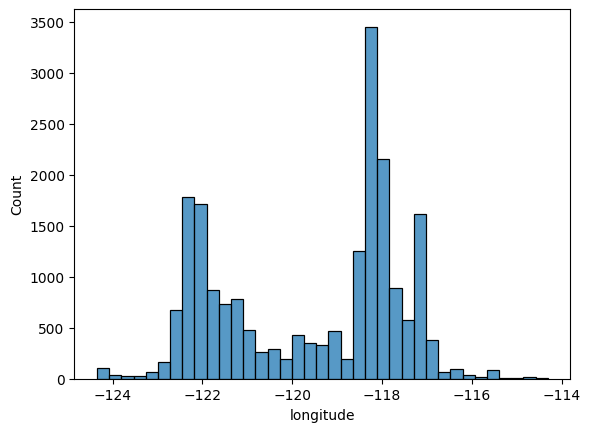

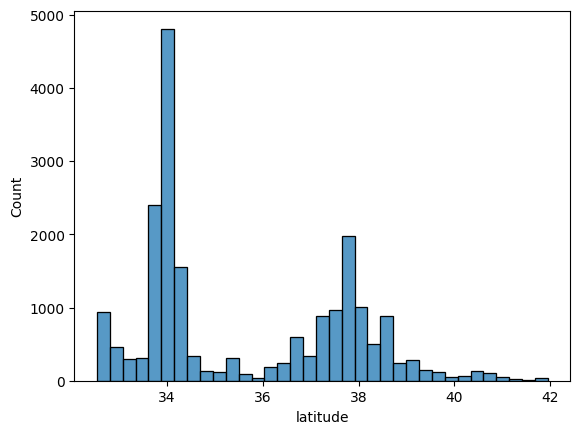

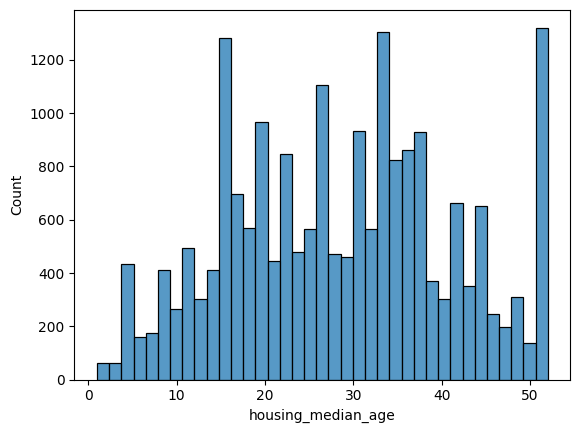

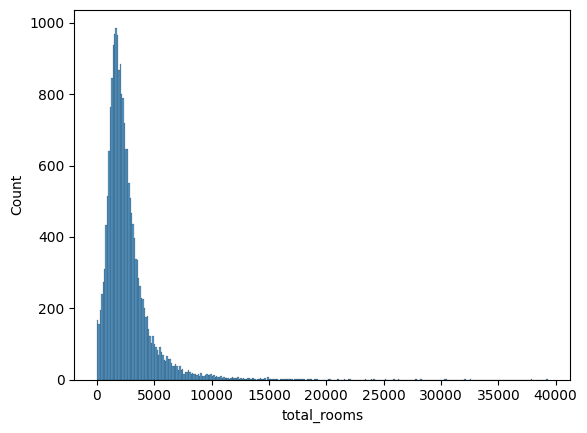

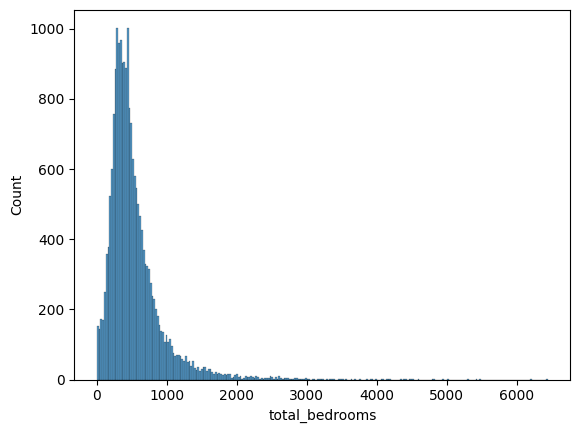

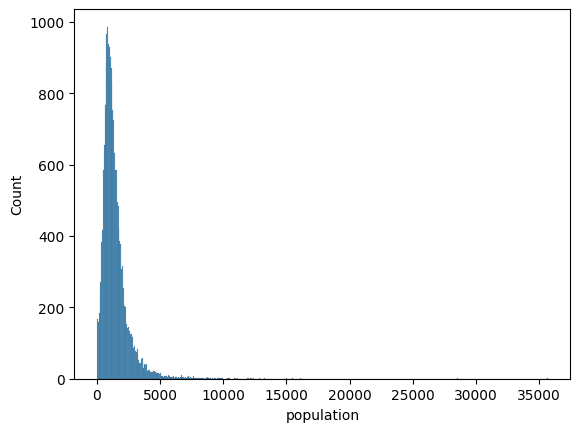

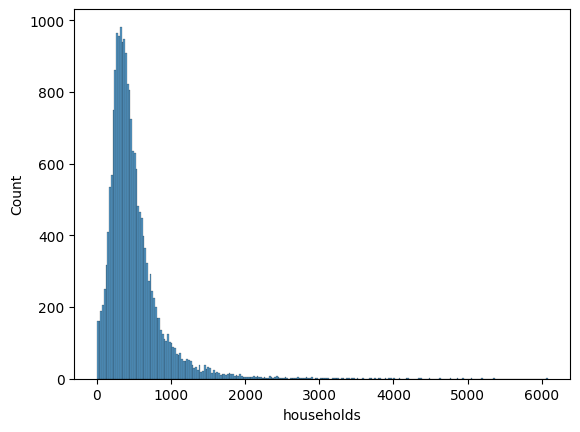

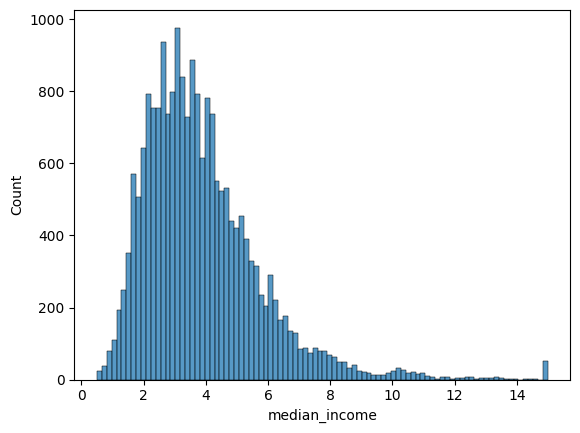

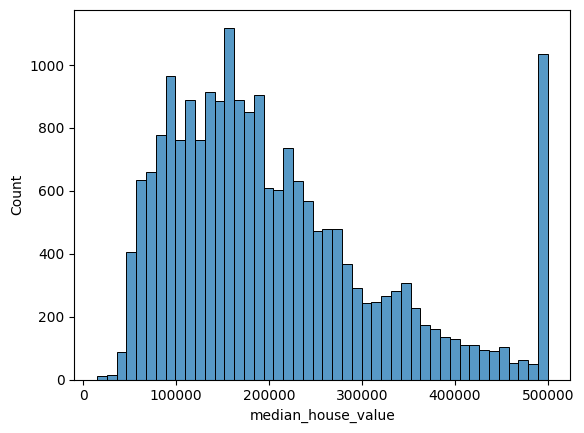

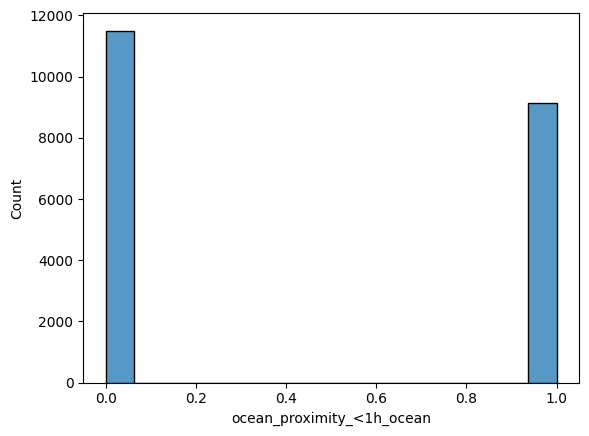

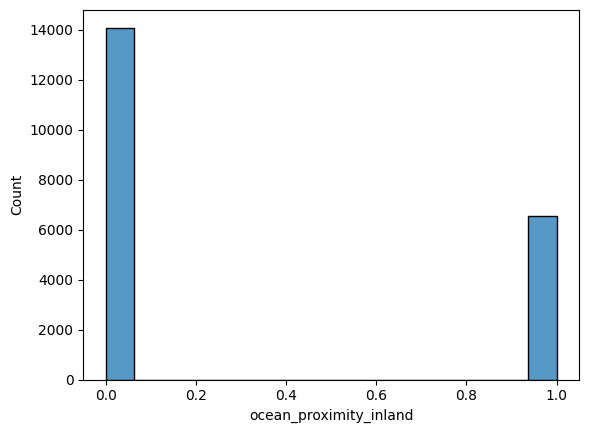

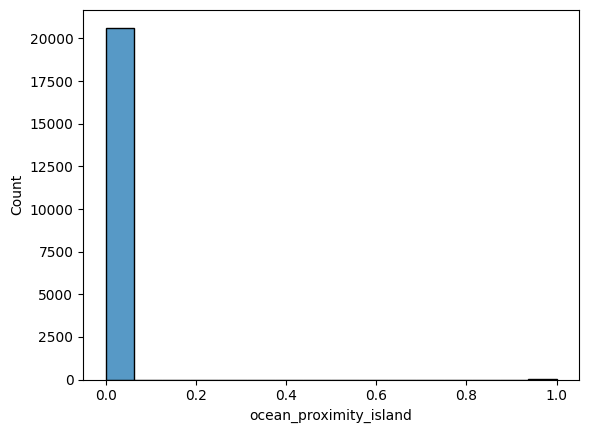

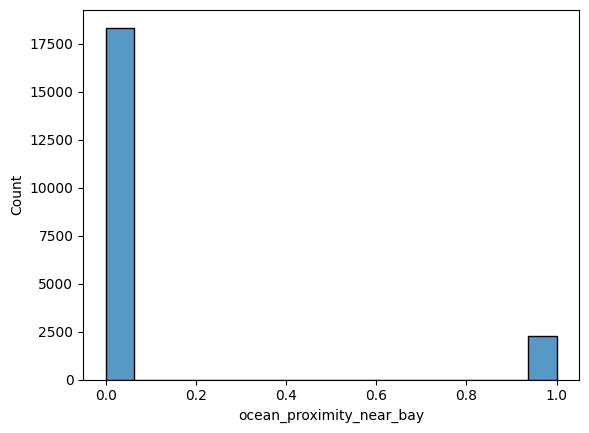

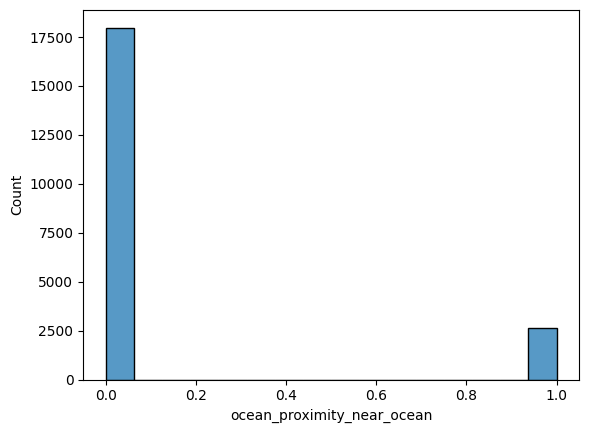

In [ ]:
# Observando a contagem dos dados
columns = df.columns.to_list()

for i in columns:
    sns.histplot(df[i])
    plt.show()

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


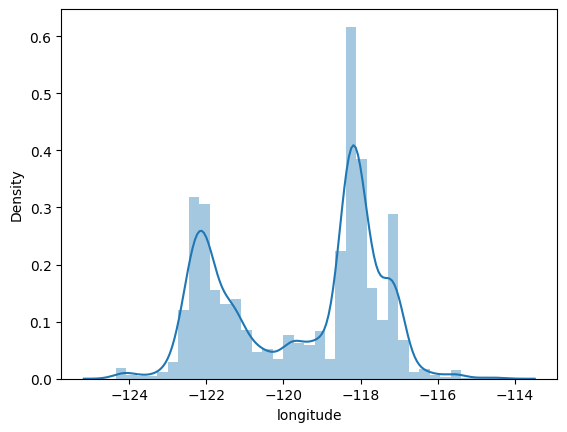

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


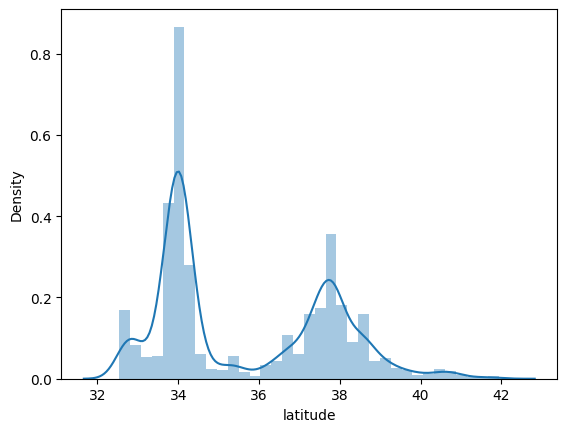

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


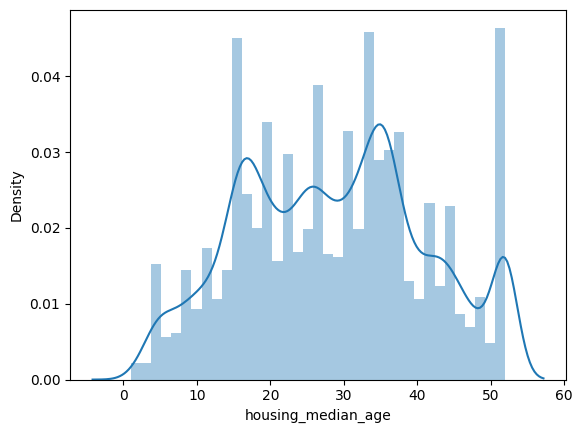

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


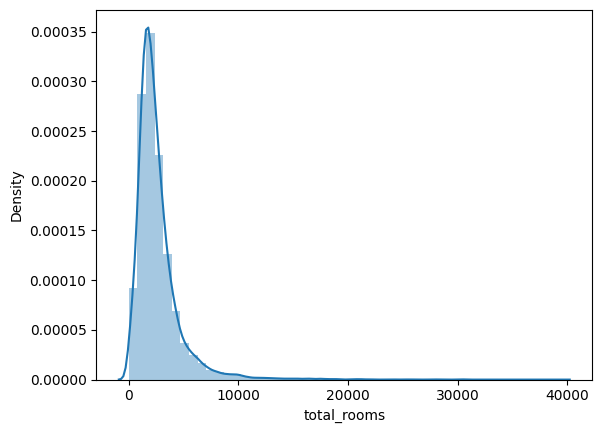

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


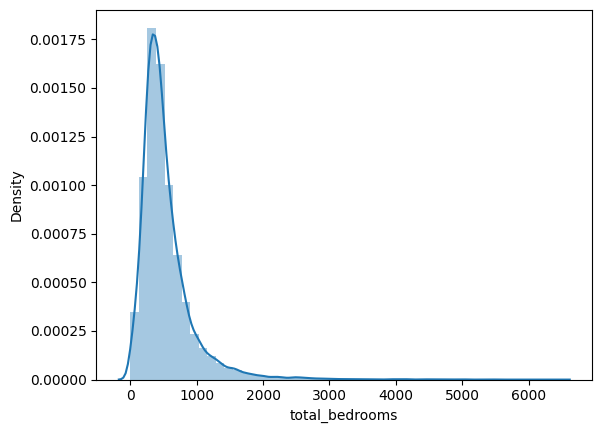

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


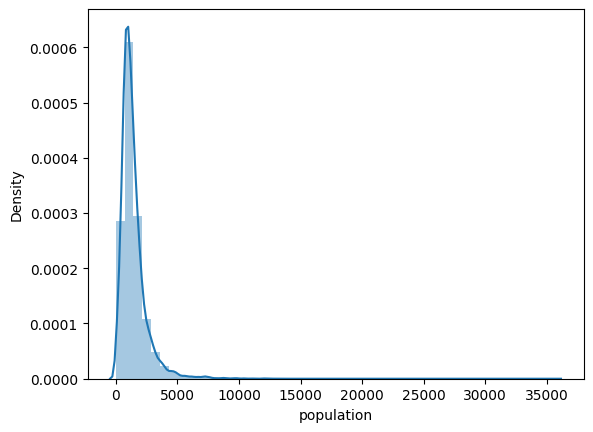

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


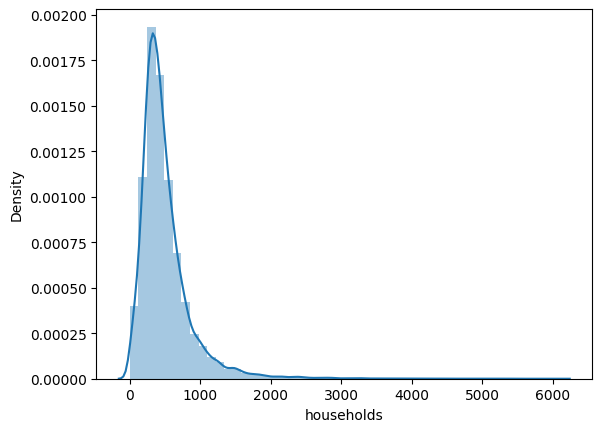

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


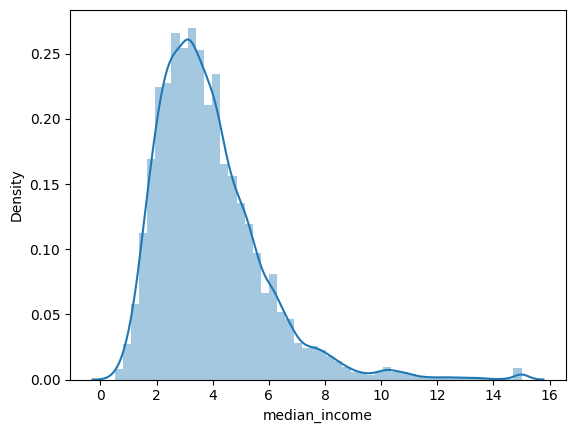

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


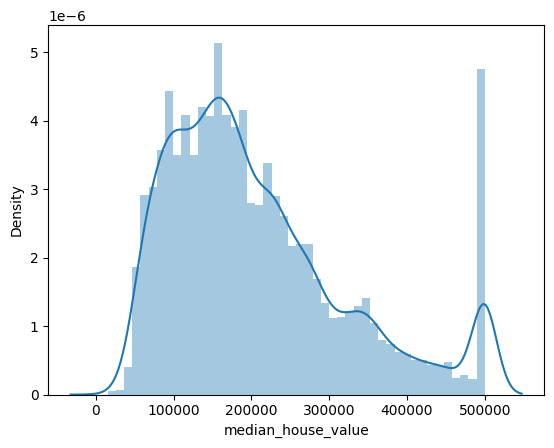

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


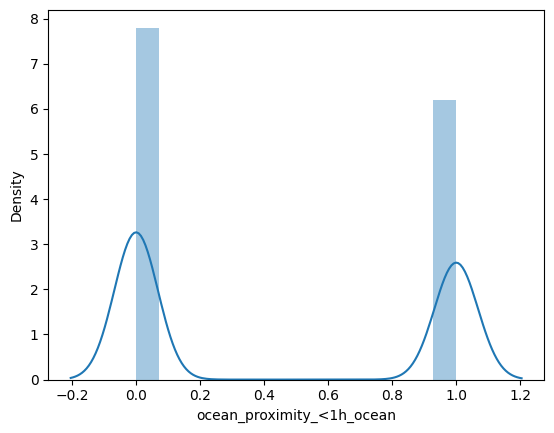

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


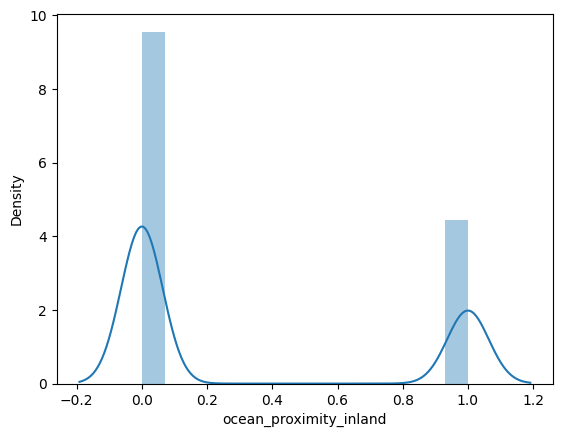

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


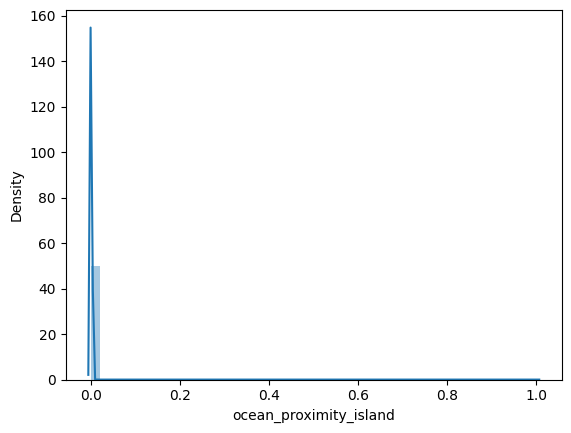

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


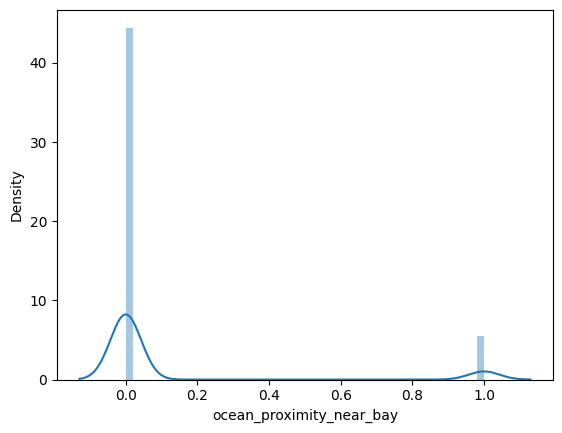

<ipython-input-78-dcf94c3ffa3c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


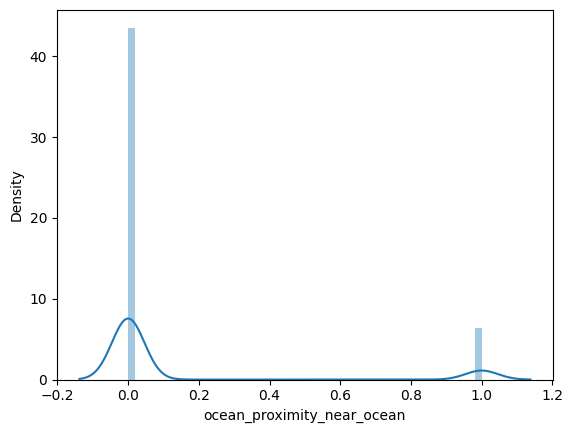

In [ ]:
# Observando as funções de densidade
for i in columns:
    sns.distplot(df[i])
    plt.show()

Text(0.5, 1.0, 'Distribuição dos preços (median_house_value)')

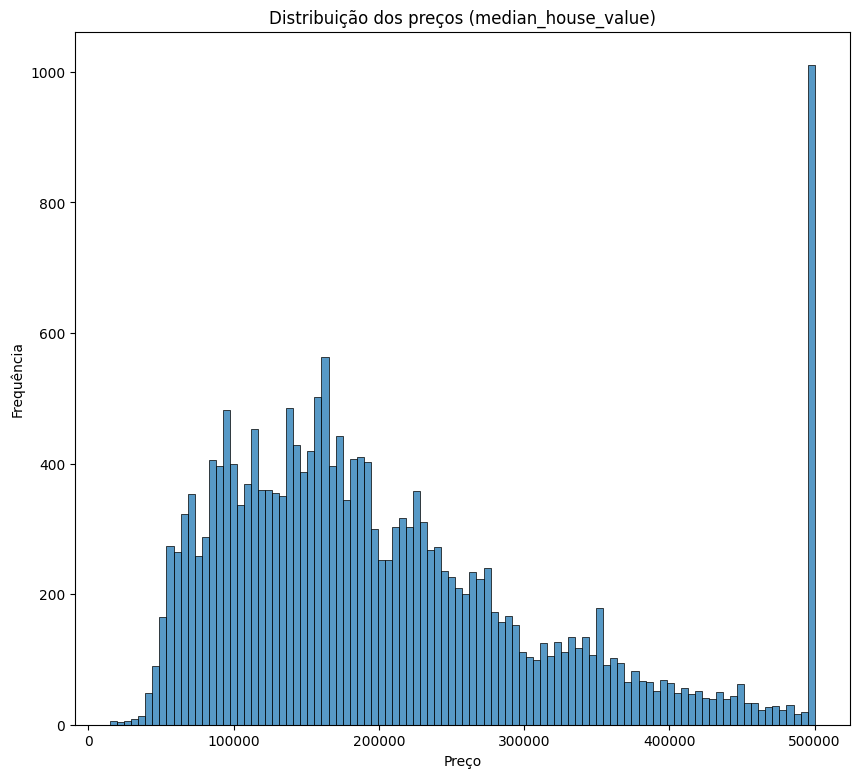

In [ ]:
plt.figure(figsize=(10, 9))

sns.histplot(df['median_house_value'], bins=100)
plt.ylabel('Frequência')
plt.xlabel('Preço')
plt.title('Distribuição dos preços (median_house_value)')

Dados com assimetria à direita, mas com uma variação muito alta no final. Este pico após os 500000 pode atrapalhar nossas predições.

### Identificando e removendo outliers

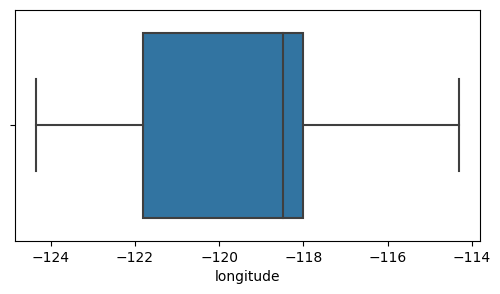

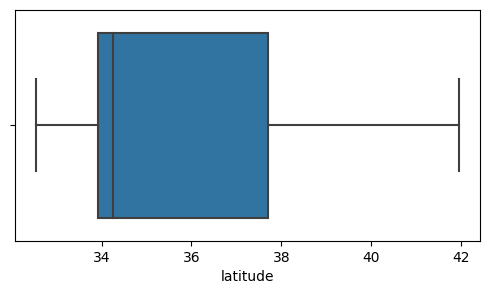

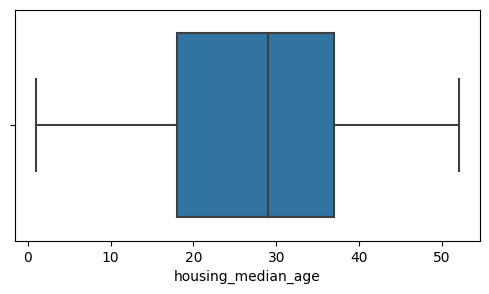

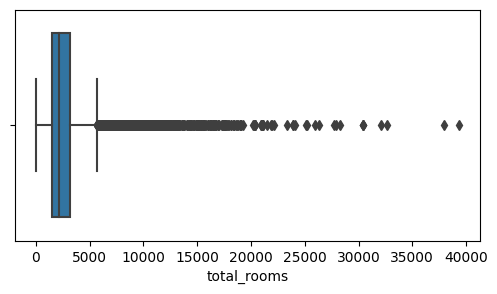

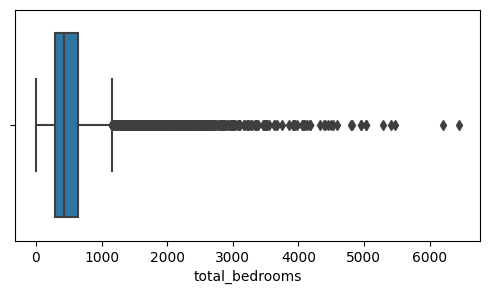

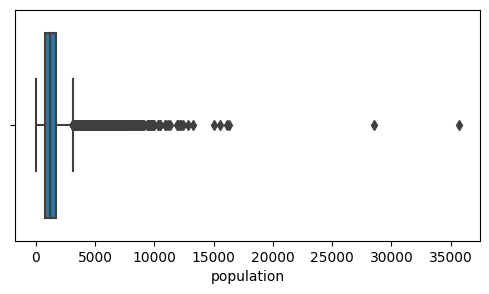

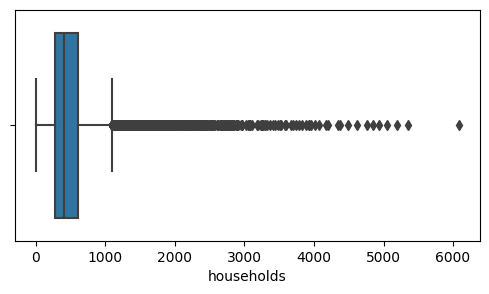

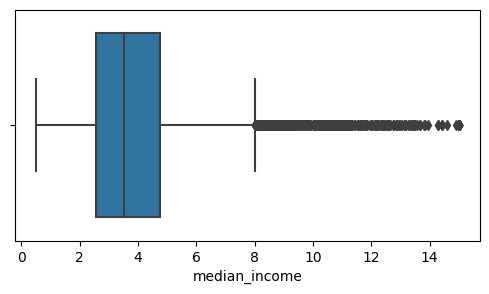

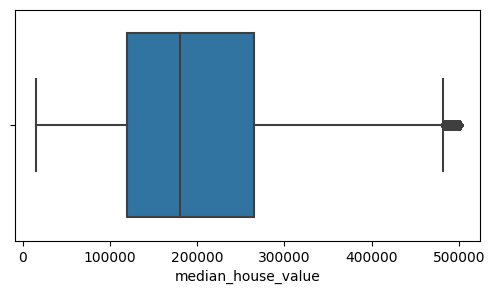

In [ ]:
for i in df.iloc[:,0:9]:
    fig, ax = plt.subplots()
    fig.set_size_inches(6,3)
    sns.boxplot(x=i,data=df,ax=ax)

Vemos que o total de quartos, o de banheiros a população na área, a médiana da renda, os households, e a mediana dos valores das casa estão com ouliers. Vamos retirar esses outliers que podem prejudicar as nossas previsões.



In [ ]:
s1 = df.shape
clean = df[['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']]
for i in clean.columns:
    qt1 = df[i].quantile(0.25)
    qt3 = df[i].quantile(0.75)
    iqr = qt3 - qt1
    lower = qt1 - (1.5 * iqr)
    upper = qt3 + (1.5 * iqr)
    min_in = df[df[i] < lower].index
    max_in = df[df[i] > upper].index
    df.drop(min_in, inplace=True)
    df.drop(max_in, inplace=True)
s2 = df.shape
outliers = s1[0] - s2[0]
print("Deleted outliers: ", outliers)


Deleted outliers:  3744


### Normalização dos dados

Primeiramente, vamos reordenar as colunas do dataframe:

In [ ]:
df = df[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income','ocean_proximity_<1h_ocean',
       'ocean_proximity_inland', 'ocean_proximity_island',
       'ocean_proximity_near_bay', 'ocean_proximity_near_ocean','median_house_value']]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1h_ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near_bay,ocean_proximity_near_ocean,median_house_value
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,0,0,0,1,0,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,0,0,0,1,0,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,0,0,0,1,0,342200
5,-122.25,37.85,52,919,213.0,413,193,4.0368,0,0,0,1,0,269700
6,-122.25,37.84,52,2535,489.0,1094,514,3.6591,0,0,0,1,0,299200


In [ ]:
# Convertendo para o formato Numpy

np_data = df.to_numpy()
nrow, ncol = df.shape

X = np_data[:,0:ncol-1]
y = np_data[:,-1]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados:
Media:  [ 6.22839322e-15 -1.69897766e-15 -1.05975834e-16  2.29614307e-16
 -9.20980464e-17 -1.18802274e-16  2.94377317e-18 -2.40968861e-16
  1.59804829e-17  7.23327122e-17  2.52323415e-18 -1.58122673e-16
 -3.86895903e-17]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Seleção de ajuste do modelo

Vamos, primeiro, separar o conjunto de dados em treino e teste:

In [ ]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Vamos começar fazendo uma regressão:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Creating and fitting the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r_squared}")

# Making predictions
y_pred = model.predict(X_test)

Mean Squared Error: 3277349121.7314672
R-squared: 0.609657098672463


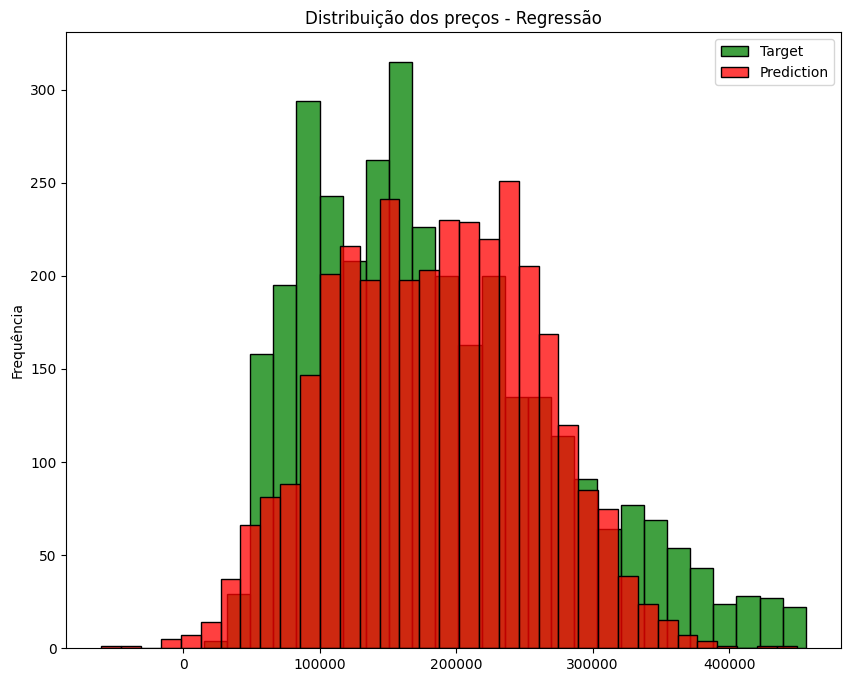

In [ ]:
plt.figure(figsize=(10, 8))

sns.histplot(y_test, label='Target', color = "green")
sns.histplot(y_pred, label='Prediction', color='red')

plt.ylabel('Frequência')
plt.title('Distribuição dos preços - Regressão')

plt.legend()
plt.show()

vemos uma discrepância grande  

Vamos utilizar a biblioteca Statsmodels para podermos visualizar com mais detalhes alguns parâmetros da nossa regressão:

In [ ]:
# Verificando a homoscedacidade
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

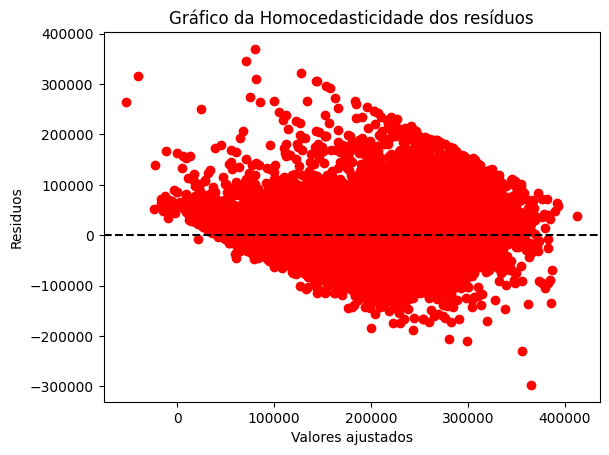

In [ ]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
residuals = model.resid

plt.scatter(model.predict(), residuals, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Gráfico da Homocedasticidade dos resíduos')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

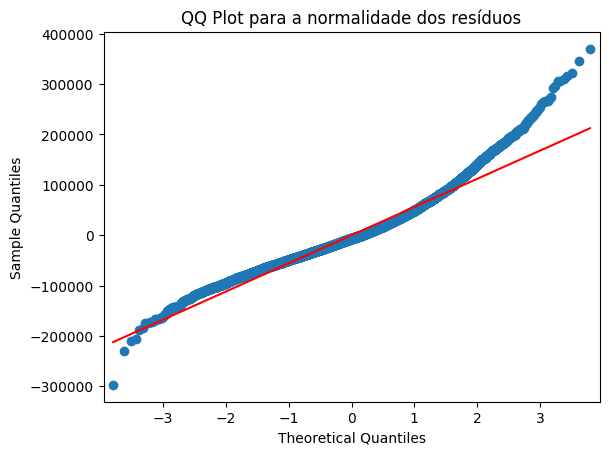

In [ ]:
# Teste de normalidade dos resíduos
sm.qqplot(residuals, line='s')
plt.title('QQ Plot para a normalidade dos resíduos')
plt.show()

In [ ]:
# Definindo o modelo e observando estatísticas de interesse
modelo = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     1926.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:03:38   Log-Likelihood:            -1.6694e+05
No. Observations:               13516   AIC:                         3.339e+05
Df Residuals:                   13503   BIC:                         3.340e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
# Teste de Kolmogorov para rejeitar, ou não, a normalidade dos resíduos
y = modelo.resid
media = np.mean(y)
std = np.std(y,ddof=1)

print('Sob H0 normal, p-valor=',stats.kstest(y,cdf='norm' , args=(media,std), N=len(y))[1])

Sob H0 normal, p-valor= 3.863299784962378e-58


Assim, rejeitamos a normalidade dos dados

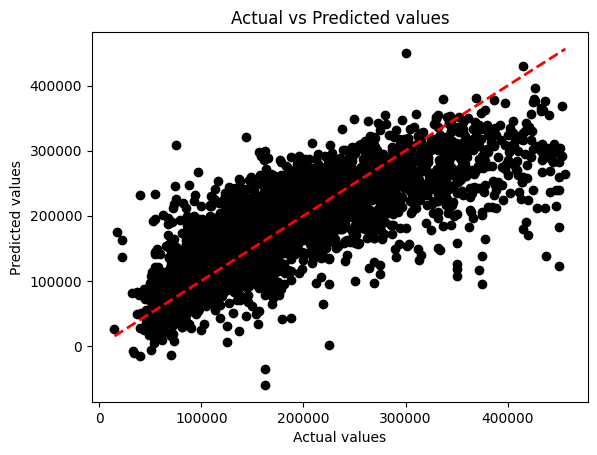

In [ ]:
# Visualize the regression line
plt.scatter(y_test, y_pred, color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs Predicted values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

Vamos, agora, fazer uma modelagem usando random forest:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Creating and training the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Set the desired number of trees (n_estimators)
random_forest_model.fit(X_train, y_train)

# Making predictions using the Random Forest model
y_pred_rf = random_forest_model.predict(X_test)

#Evaluating the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r_squared_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (Random Forest): {mse_rf}")
print(f"R-squared (Random Forest): {r_squared_rf}")

Mean Squared Error (Random Forest): 1902773099.3766894
R-squared (Random Forest): 0.7733735575335073


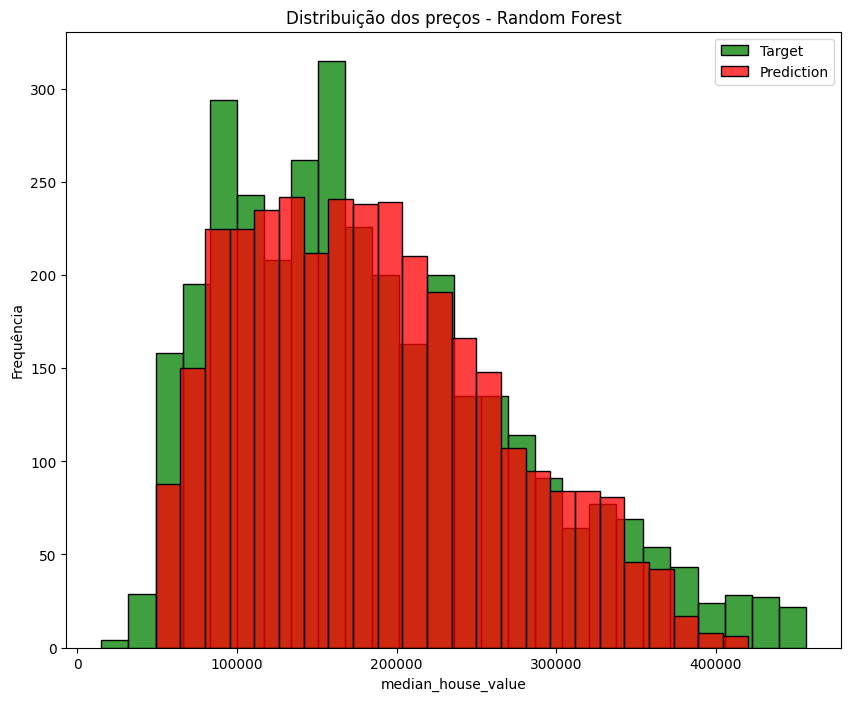

In [ ]:
# Plotting the actual values vs. Predicted values using the Random Forest model
plt.figure(figsize=(10, 8))

sns.histplot(y_test, label='Target', color = "green")
sns.histplot(y_pred_rf, label='Prediction', color='red')

plt.ylabel('Frequência')
plt.title('Distribuição dos preços - Random Forest')

plt.legend()
plt.show()

Podemos perceber que o Random Forest obteve um desempenho um pouco melhor que a Regressão, com um $MSE$ menor, um $R^2$ maior e, consequentemente, uma distribuição mais certeira comparada com os labels originais.

### Análise de componentes principais (PCA)

In [ ]:
# Análise de Componentes Principais
# Decompondo a matriz de variâncias e covariâncias em componentes principais.

X = np.matrix(df.iloc[:,0:10])
S = np.cov(np.transpose(X))
X = np.asarray(X)

In [ ]:
# Coletando as variâncias

np.diagonal(S)

array([4.02297130e+00, 4.72518529e+00, 1.49089198e+02, 1.05128902e+06,
       3.97910918e+04, 3.02240894e+05, 3.46618782e+04, 2.09091481e+00,
       2.44970271e-01, 2.23752979e-01])

In [ ]:
# Realizando um teste PCA com 8 componentes principais

pca = PCA(n_components=8)
pca

PCA(n_components=8)

In [ ]:
pca.fit(X)

PCA(n_components=8)

In [ ]:
# Pesos das componentes principais

pca.components_[0,:]

array([ 2.15908088e-05, -3.59328024e-05, -2.85959142e-03,  8.87865860e-01,
        1.58275280e-01,  4.05519557e-01,  1.48958935e-01,  3.11368328e-04,
        8.23055135e-06, -4.60764840e-06])

In [ ]:
# Quantas componentes explicam ao menos 90% da variabilidade dos dados?

# Variância das componentes principais

pca.explained_variance_ratio_

np.round(pca.explained_variance_ratio_,2)

array([0.92, 0.08, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ])

Apenas uma componente explicaria mais de 90% da variância dos dados

In [ ]:
# Observândo a variância explicada acumulada

pca.explained_variance_ratio_.cumsum()

array([0.91509229, 0.99173536, 0.99901025, 0.99989958, 0.99999309,
       0.99999873, 0.99999962, 0.99999986])

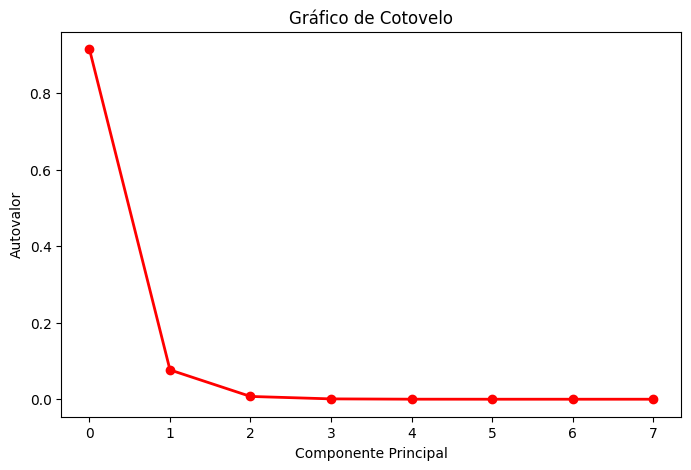

In [ ]:
fig = plt.figure(figsize=(8,5))

plt.plot(pca.explained_variance_ratio_,  'ro-', linewidth=2)
plt.title('Gráfico de Cotovelo')
plt.xlabel('Componente Principal')
plt.ylabel('Autovalor')

plt.show()

Pelo gráfico de cotovelo observamos que duas componentes já seriam suficientes para explicar a variância dos dados.

In [ ]:
pca.transform(X)

array([[-8.72806029e+02,  3.57453169e+02, -9.56982414e+01, ...,
         2.18269872e+00, -2.94504264e+00, -8.57727613e-01],
       [-1.00564377e+03,  2.10590988e+02, -2.04492070e+01, ...,
         2.51365313e+00, -2.13986522e+00, -5.73182970e-01],
       [-6.76308297e+02,  3.51223458e+02, -1.50168922e+01, ...,
         2.39142434e+00, -1.81866779e-01,  2.63751684e-01],
       ...,
       [ 1.18087906e+02,  1.99285991e+02,  6.60879457e+01, ...,
         3.73158274e+00,  1.89335458e+00, -3.53125409e-01],
       [-3.64143726e+02,  2.78232799e+02,  6.80864408e+01, ...,
         3.61311570e+00,  1.63237901e+00, -3.47297364e-01],
       [ 7.78828263e+02,  7.35609424e+01,  7.13888446e+01, ...,
         3.92080555e+00,  1.02305237e+00, -6.45454754e-01]])

In [ ]:
# Considerando as 2 componentes principais

pca = PCA(n_components=2)
pca.fit(X)

pca.components_

array([[ 2.15908088e-05, -3.59328024e-05, -2.85959142e-03,
         8.87865860e-01,  1.58275280e-01,  4.05519557e-01,
         1.48958935e-01,  3.11368328e-04,  8.23055135e-06,
        -4.60764840e-06],
       [-1.14431677e-03,  1.56169630e-03, -3.80266605e-03,
         4.36396409e-01, -6.55643714e-02, -8.91114787e-01,
        -1.05606874e-01,  1.66242549e-03, -3.18014075e-04,
         1.98860565e-04]])

### Considerações Finais

Neste trabalho de Ciência de Dados, utilizamos a base de dados do censo na Califórnia para ajustar um modelo que preveja o valor de casas de acordo com sua respectiva localização, número de cômodos, população da região, entre outros atributos. Para isso, utilizamos dois métodos distintos: Regressão Linear e Random Forest.

O modelo de regressão linear apresentou um Mean Squared Error $MSE = 3277349121,73$ e um coeficiente de determinação $R^2 = 0,6097$. Enquanto que o Random Forest obteve um $MSE = 1906218891,29$ e $R^2 = 0,7729$. É importante frisar que estamos trabalhando com grandezas de natureza ampla que são os preços de casas, o que explica em parte o alto valor dos erros.

Assim, vemos que a abordagem do Random Forest proporcionou uma melhoria significativa nos resultados, demonstrando ser mais eficaz em capturar a complexidade dos dados, resultando em uma melhor capacidade de prever os preços das casas. A capacidade do modelo de lidar com interações complexas entre os atributos foi crucial para melhorar a precisão das previsões. Por outro lado, recomenda-se a realização de uma validação cruzada mais robusta e a otimização dos hiperparâmetros do Random Forest para levar a melhorias adicionais.

Outrossim, uma consideração importante para a análise do desempenho do método de Regressão Linear é a verificação de uma relação não-linear entre os dados, da multicolinearidade entre as covariáveis (como visto, por exemplo, na relação renda x localização), a não-normalidade dos erros (verificado no Gráfico de Homocedasticidade), dentre outras razões.
